In [1]:
import xarray as xr
import numpy as np
from os.path import join
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, voronoi_plot_2d, cKDTree

In [2]:
DATA_DIR = "../skeleton_framework/"
order6_data_fn = 'compress.isosph.CESM2.historical.r1i1p1f1.Input.Exp8_fixed.nc'


In [3]:
ds = xr.open_dataset(join(DATA_DIR, order6_data_fn))

#### Breakdown of different levels
- level-0(2**0=1): 12 vertices
- level-1(2**1=2): 42 vertices
- level-2(2**2=4): 162 vertices
- level-3(2**3=8): 642 vertices
- level-4(2**4=16): 2562 vertices
- level-5(2**5=32): 10242 vertices
- level-6(2**6=64): 40962 vertices

In [4]:
lon_l6 = ds.lon.data
lat_l6 = ds.lat.data

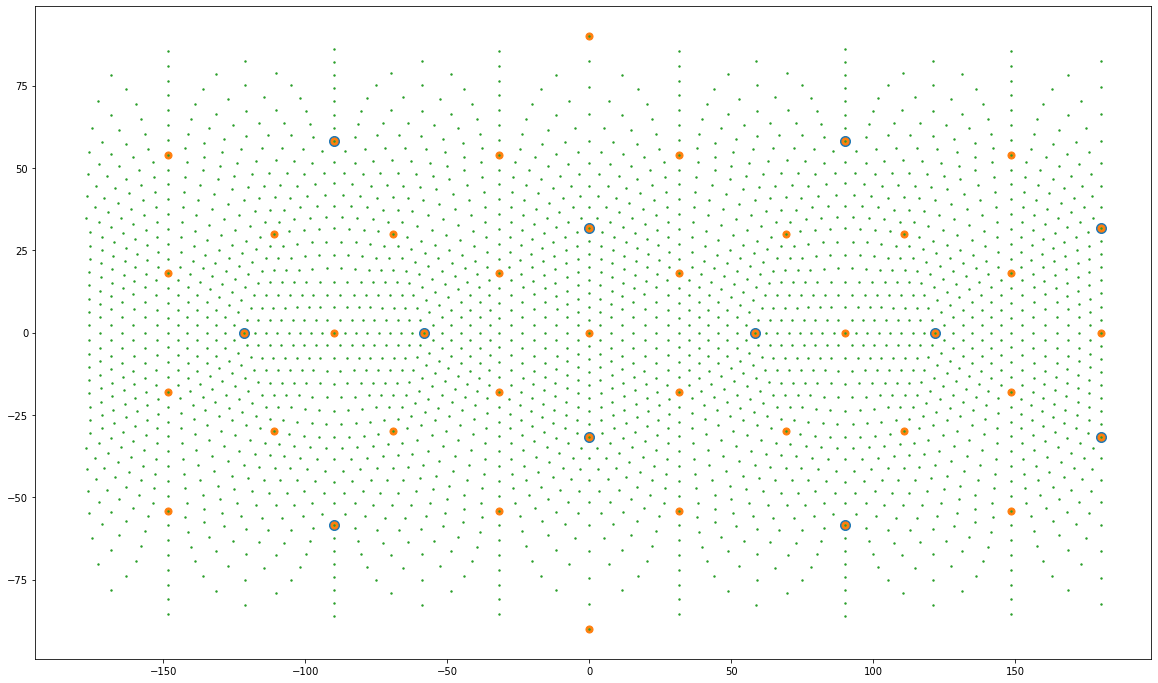

In [5]:
plt.figure(figsize=(20,12))
plt.scatter(x=lon_l6[:12], y=lat_l6[:12], s=100)
plt.scatter(x=lon_l6[:42], y=lat_l6[:42], s=50)
plt.scatter(x=lon_l6[:2562], y=lat_l6[:2562], s=2)

In [6]:
base_point_array_l1 = np.vstack((lon_l6[:42], lat_l6[:42])).T

In [7]:
def lonlat_to_xyz(lon,lat):
    r= 1000.0
    x = r*np.cos(lat*np.pi/180.0)*np.cos(lon*np.pi/180.0)
    y = r*np.cos(lat*np.pi/180.0)*np.sin(lon*np.pi/180.0)
    z = r*np.sin(lat*np.pi/180.0)
    return x,y,z

def xyz_to_lonlat(x,y,z):
    r=1000.0
    lon = np.arctan(y/x)*(180.0/np.pi)
    lat = np.arcsin(z/r)*(180.0/np.pi)

In [8]:
def convert_to_xyz(lon_vec, lat_vec):
    x_vec=[];y_vec=[];z_vec=[]
    for lon, lat in zip(lon_vec, lat_vec):
        x,y,z= lonlat_to_xyz(lon, lat)
        x_vec.append(x)
        y_vec.append(y)
        z_vec.append(z)
    return x_vec, y_vec, z_vec

In [9]:
x_l6, y_l6, z_l6 = convert_to_xyz(lon_l6, lat_l6)

In [10]:
base_point_array_l1 = np.vstack((lon_l6[:42], lat_l6[:42])).T
base_point_array_l1_xyz = np.vstack((x_l6[:42], y_l6[:42], z_l6[:42])).T

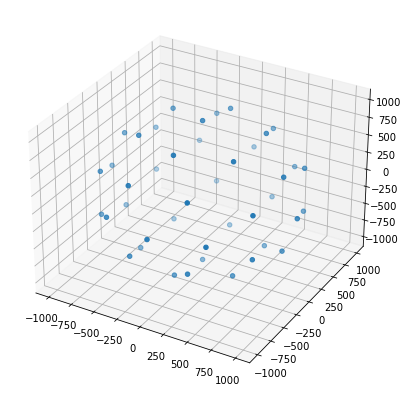

In [11]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")


ax.scatter3D( x_l6[:42], y_l6[:42], z_l6[:42])
plt.show()

In [12]:
print(np.amax(x_l6), np.amin(x_l6), np.amax( y_l6), np.amin(y_l6), np.amax(z_l6), np.amin(z_l6))

1000.0 -1000.0 1000.0 -1000.0 1000.0 -1000.0


### test voronoi tesselation of the points around the base points

In [13]:
vor = Voronoi(base_point_array_l1)

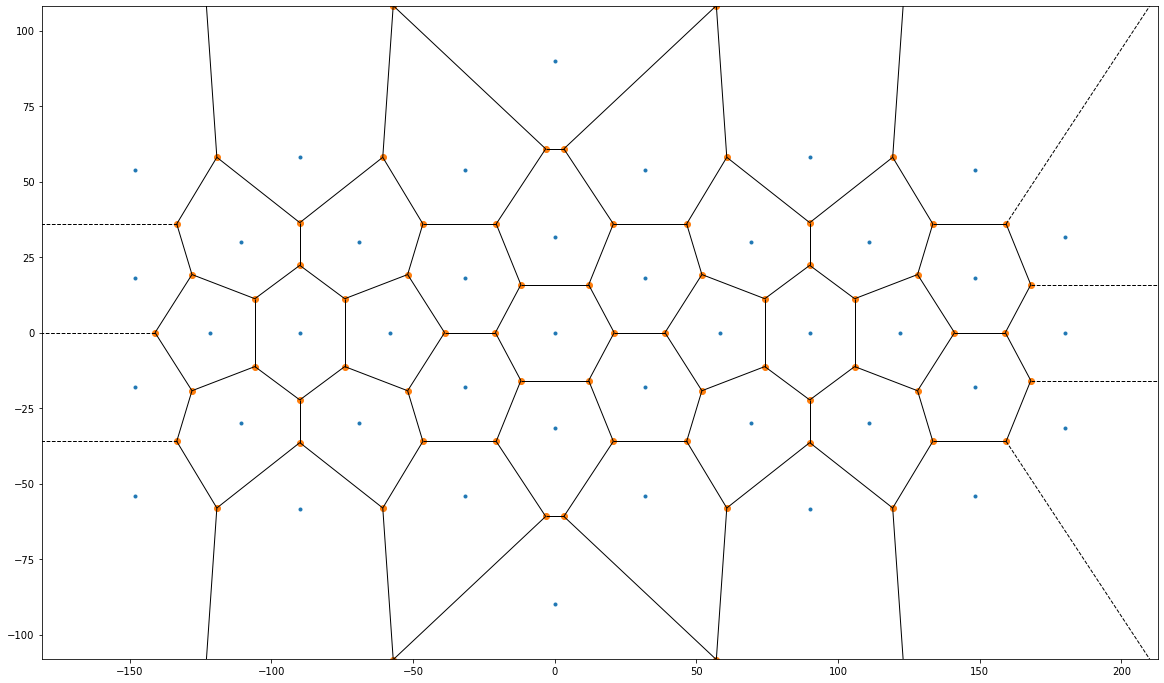

In [14]:
plt.rcParams['figure.figsize'] = [20,12]
voronoi_plot_2d(vor)

plt.show()


### cKD tree partitions

In [28]:
#highest resolution to query for
query_array_xyz = np.vstack((x_l6[:], y_l6[:], z_l6[:])).T

def cKDT_based_partitions(base_points):
    voronoi_kdtree = cKDTree(base_points)
    test_point_dist, test_point_regions = voronoi_kdtree.query(query_array_xyz)
    return test_point_regions

def visualize_partitions(base_points, labels, title):
    plt.figure(figsize=(15,8))
    plt.scatter(x=base_points[:,0], y=base_points[:,1], s=20)
    plt.scatter(x=lon_l6[:], y=lat_l6[:], s=2, c=labels, cmap=plt.get_cmap('flag'))
    plt.title(title)
    plt.show()

In [29]:
l1_labels = cKDT_based_partitions(base_point_array_l1_xyz)

In [32]:
base_point_array_l0 = np.vstack((lon_l6[:12], lat_l6[:12])).T
base_point_array_l0_xyz = np.vstack((x_l6[:12], y_l6[:12], z_l6[:12])).T
l0_labels = cKDT_based_partitions(base_point_array_l0_xyz)

base_point_array_l2 = np.vstack((lon_l6[:162], lat_l6[:162])).T
base_point_array_l2_xyz = np.vstack((x_l6[:162], y_l6[:162], z_l6[:162])).T
l2_labels = cKDT_based_partitions(base_point_array_l2_xyz)

base_point_array_l3 = np.vstack((lon_l6[:642], lat_l6[:642])).T
base_point_array_l3_xyz = np.vstack((x_l6[:642], y_l6[:642], z_l6[:642])).T
l3_labels = cKDT_based_partitions(base_point_array_l3_xyz)

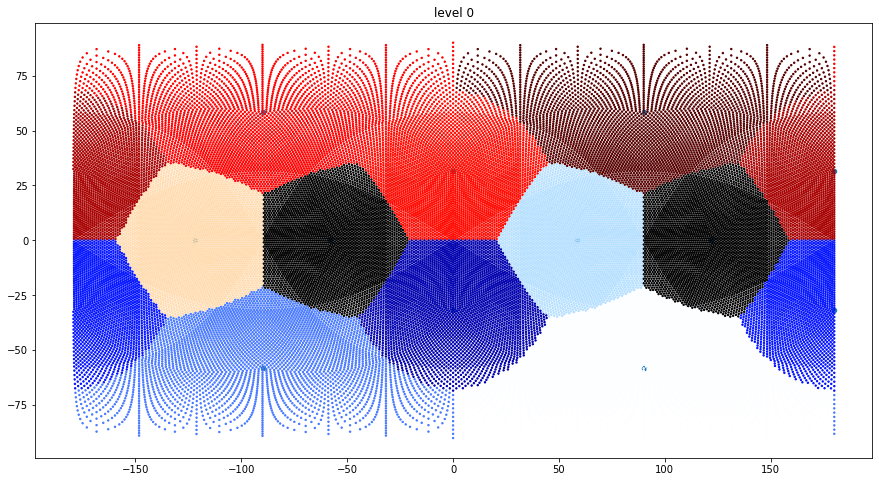

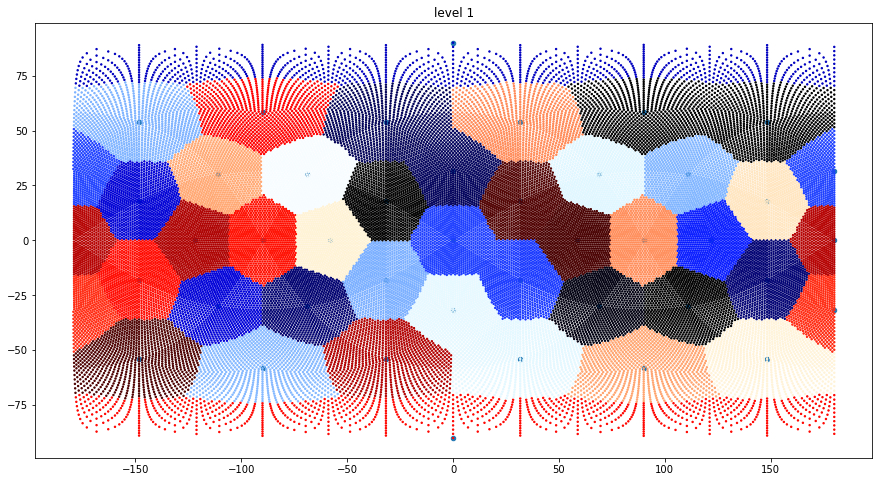

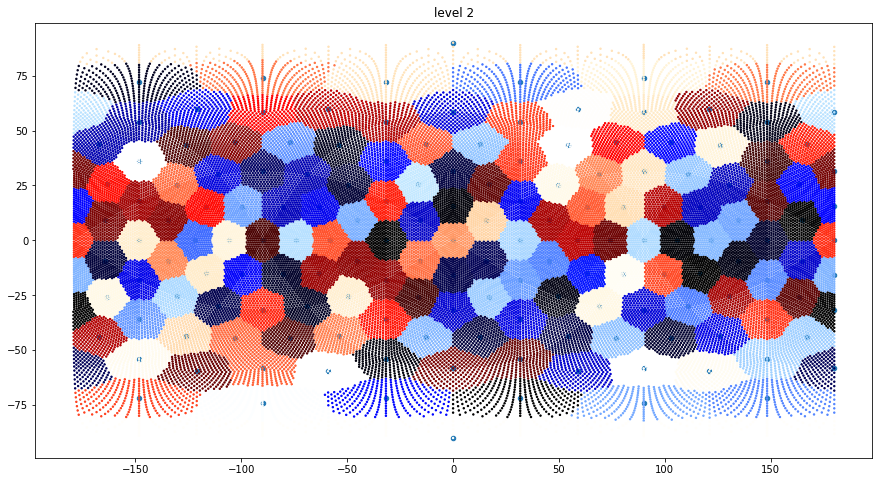

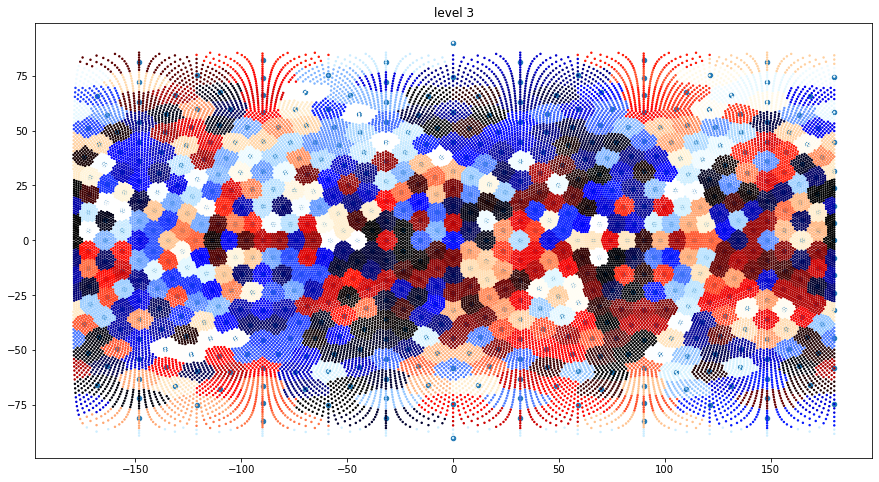

In [33]:
visualize_partitions(base_point_array_l0, l0_labels, "level 0")
visualize_partitions(base_point_array_l1, l1_labels, "level 1")
visualize_partitions(base_point_array_l2, l2_labels, "level 2")
visualize_partitions(base_point_array_l3, l3_labels, "level 3")

In [27]:
import pandas as pd

In [28]:
#create parition information dataframe
def get_lat_lon_partition_df(lat, lon, pid):
    new_array = np.vstack((lat, lon, pid))
    column_name = ['lat', 'lon', 'pid']
    # creating the dataframe
    new_df = pd.DataFrame(data = new_array.T, columns = column_name)
    
    return new_df

In [29]:
l0_pid_df = get_lat_lon_partition_df(lat_l6, lon_l6, l0_labels)
l1_pid_df = get_lat_lon_partition_df(lat_l6, lon_l6, l1_labels)
l2_pid_df = get_lat_lon_partition_df(lat_l6, lon_l6, l2_labels)
l3_pid_df = get_lat_lon_partition_df(lat_l6, lon_l6, l3_labels)

<AxesSubplot:>

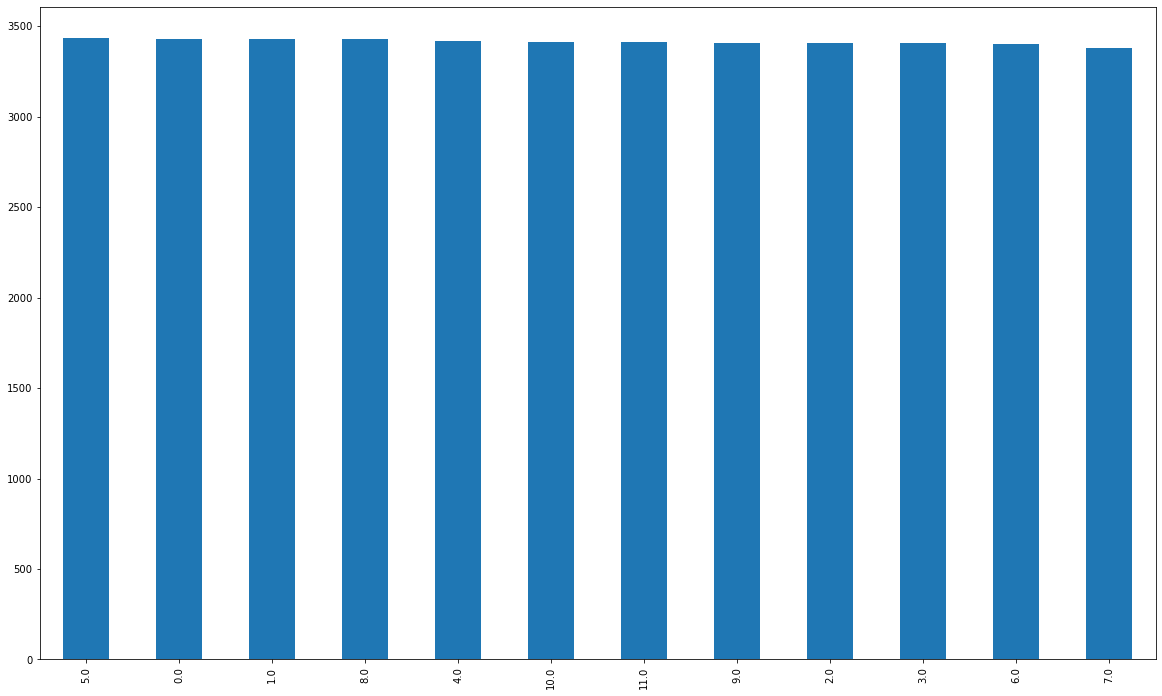

In [30]:
fig, ax = plt.subplots()
l0_pid_df['pid'].value_counts().plot(ax=ax, kind='bar')

<AxesSubplot:>

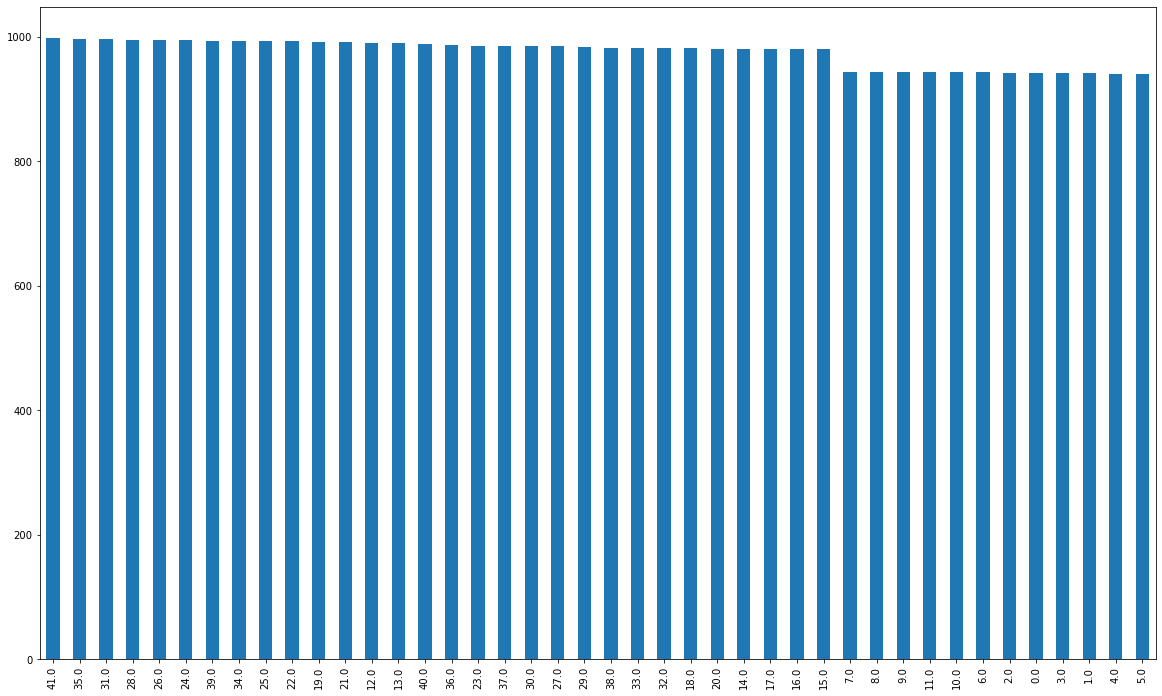

In [31]:
fig, ax = plt.subplots()
l1_pid_df['pid'].value_counts().plot(ax=ax, kind='bar')

<AxesSubplot:>

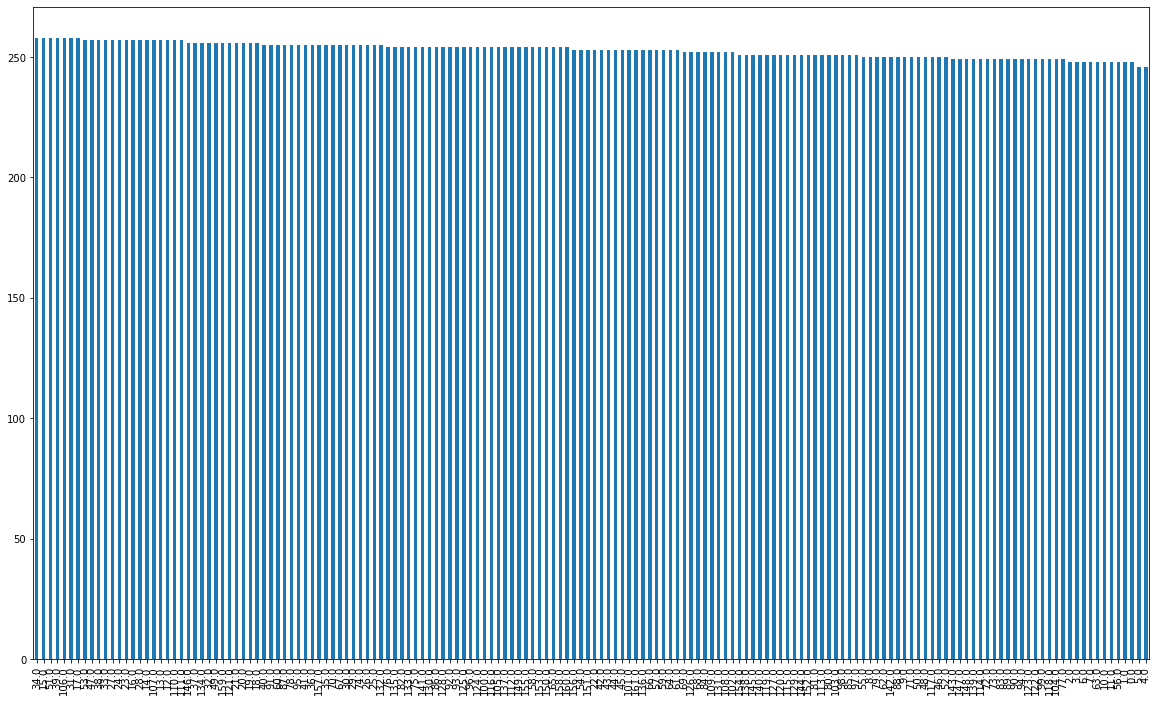

In [32]:
fig, ax = plt.subplots()
l2_pid_df['pid'].value_counts().plot(ax=ax, kind='bar')

<AxesSubplot:>

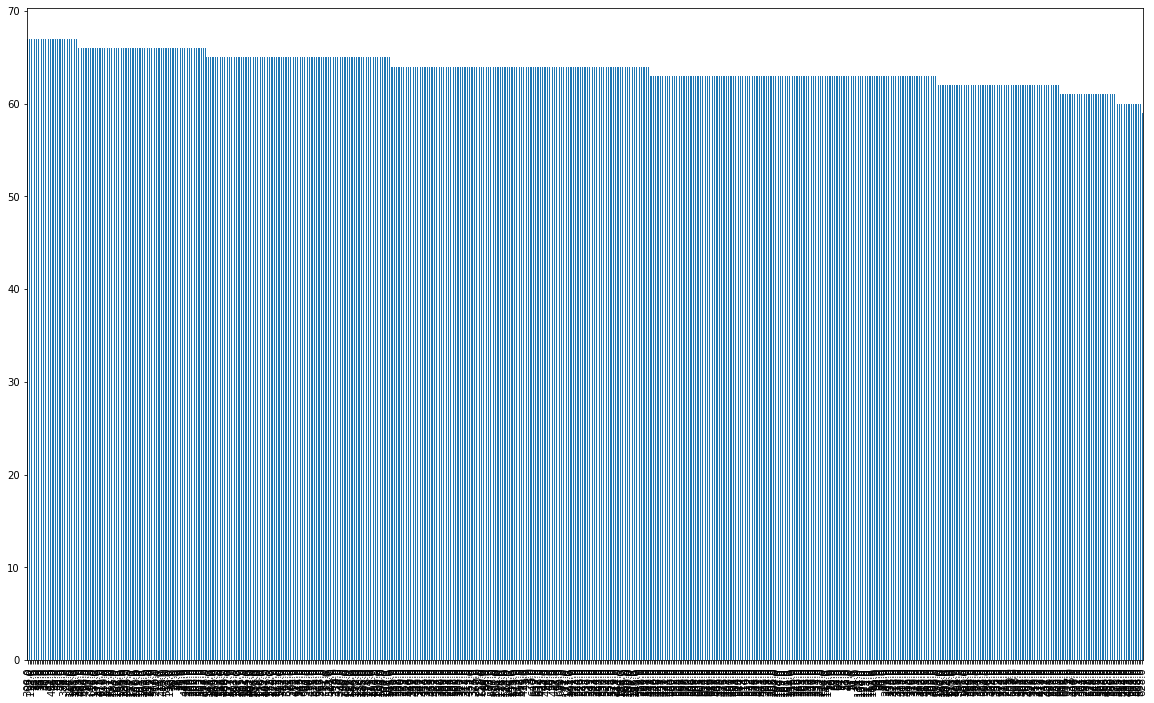

In [33]:
fig, ax = plt.subplots()
l3_pid_df['pid'].value_counts().plot(ax=ax, kind='bar')